In [3]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("DynamicalSystems")
Pkg.add("Distributions")
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
import Convex as cvx 
import ECOS
using JLD2
using Test
using Random
using ProgressMeter
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))
using GaussianFilters, LinearAlgebra, Distributions
include(joinpath(@__DIR__,"utils/rendezvous.jl"))

  Activating environment at `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Project.toml`
  No Changes to `~/Desktop/CMU/16745_optimal_control/OCRL_Project/Manifest.toml`


thruster_model (generic function with 1 method)

In [4]:
# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function dynamics(params::NamedTuple, x::Vector, u)
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    nx, nu = size(B)
    dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    Ad = dt_mat[1:nx, 1:nx]
    Bd = dt_mat[1:nx, (nx+1):end]

    return Ad, Bd

end

function create_dynamics(dt::Real)::Tuple{Matrix,Matrix}
    mu = 3.986004418e14 # standard gravitational parameter
    a = 6971100.0       # semi-major axis of ISS
    n = sqrt(mu/a^3)    # mean motion

    # continuous time dynamics ẋ = Ax + Bu
    A = [0     0  0    1   0   0; 
         0     0  0    0   1   0;
         0     0  0    0   0   1;
         3*n^2 0  0    0   2*n 0;
         0     0  0   -2*n 0   0;
         0     0 -n^2  0   0   0]
         
    B = Matrix([zeros(3,3);0.1*I(3)])

    # TODO: convert to discrete time X_{k+1} = Ad*x_k + Bd*u_k
    nx, nu = size(B)
    dt_mat = exp([A B;zeros(nu, nx+nu)]*dt)

    Ad = dt_mat[1:nx, 1:nx]
    Bd = dt_mat[1:nx, (nx+1):end]

    return Ad, Bd
end

function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

function ihlqr(A::Matrix,       # vector of A matrices 
               B::Matrix,       # vector of B matrices
               Q::Matrix,       # cost matrix Q 
               R::Matrix;       # cost matrix R 
               max_iter = 1000, # max iterations for Ricatti 
               tol = 1e-5       # convergence tolerance
               )::Tuple{Matrix, Matrix} # return two matrices 
        
    # get size of x and u from B 
    nx, nu = size(B)
        
    # initialize S with Q
    P = deepcopy(Q)
    
    # Ricatti 
    for ricatti_iter = 1:max_iter 
        K = (R + B' * P * B) \ (B' * P * A)
        P_new = Q + K' * R * K + (A - B * K)' * P * (A - B * K)

        if norm(P_new - P) <= tol
            return P_new, K
        end
        
        # update P for the next iteration
        P = P_new
    end
    error("ihlqr did not converge")
end

function fhlqr(A::Matrix, # A matrix 
    B::Matrix, # B matrix 
    Q::Matrix, # cost weight 
    R::Matrix, # cost weight 
    Qf::Matrix,# term cost weight 
    N::Int64   # horizon size 
    )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 

# check sizes of everything 
nx,nu = size(B)
@assert size(A) == (nx, nx)
@assert size(Q) == (nx, nx)
@assert size(R) == (nu, nu)
@assert size(Qf) == (nx, nx)

# instantiate S and K 
P = [zeros(nx,nx) for i = 1:N]
K = [zeros(nu,nx) for i = 1:N-1]


# initialize S[N] with Qf 
P[N] = deepcopy(Qf)

# Ricatti 
for k = N-1:-1:1
K[k] .= (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
P[k] .= Q + A'*P[k+1]*(A-B*K[k])
end

return P, K 
end

fhlqr (generic function with 1 method)

In [5]:
function convex_trajopt(A::Matrix, # discrete dynamics A 
    B::Matrix, # discrete dynamics B 
    X_ref::Vector{Vector{Float64}}, # reference trajectory 
    x0::Vector, # initial condition 
    xg::Vector, # goal state 
    u_min::Vector, # lower bound on u 
    u_max::Vector, # upper bound on u
    N::Int64, # length of trajectory 
    )::Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}} # return Xcvx,Ucvx

    # get our sizes for state and control
    nx,nu = size(B)

    @assert size(A) == (nx, nx)
    @assert length(x0) == nx 
    @assert length(xg) == nx 

    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N)
    U = cvx.Variable(nu,N-1)

    # TODO: implement cost
    obj = 0 
    for k = 1:(N-1)
        x_k = X[:,k]
        u_k = U[:,k]
        obj += 1/2*cvx.quadform(x_k-X_ref[k],Q) + 1/2*cvx.quadform(u_k,R)
    end

    # terminal cost
    obj += 1/2*cvx.quadform(X[:,N]-X_ref[N],Q)

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 

    prob.constraints += (X[:,1] == x0)
    for k = 1:(N-1)
        prob.constraints += (X[:,k+1] == A*X[:,k]+B*U[:,k])
        prob.constraints += (U[:,k]<=u_max)
        prob.constraints += (U[:,k]>=u_min)
        prob.constraints += (X[2,k] <= xg[2])
    end
    prob.constraints += (X[:,N] == xg)

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    X = X.value
    U = U.value

    Xcvx = vec_from_mat(X)
    Ucvx = vec_from_mat(U)

    return Xcvx, Ucvx
end

convex_trajopt (generic function with 1 method)

In [6]:
function RHE(A::Matrix, # discrete dynamics A 
    B::Matrix, # discrete dynamics B 
    z::Vector{Vector{Float64}}, # reference trajectory 
    h_x::Vector, # initial condition 
    xg::Vector, # goal state 
    u_min::Vector, # lower bound on u 
    u_max::Vector, # upper bound on u
    N::Int64, # length of trajectory 
    )::Tuple{Vector{Vector{Float64}}, Vector{Vector{Float64}}} # return Xcvx,Ucvx

    # get our sizes for state and control
    nx,nu = size(B)

    @assert size(A) == (nx, nx)
    @assert length(x0) == nx 
    @assert length(xg) == nx 

    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N)
    U = cvx.Variable(nu,N-1)

    # TODO: implement cost
    obj = 0 
    for k = 1:(N-1)
        x_k = X[:,k]
        u_k = U[:,k]
        obj += 1/2*cvx.quadform(x_k-X_ref[k],Q) + 1/2*cvx.quadform(u_k,R)
    end

    # terminal cost
    obj += 1/2*cvx.quadform(X[:,N]-X_ref[N],Q)

    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 

    prob.constraints += (X[:,1] == x0)
    for k = 1:(N-1)
        prob.constraints += (X[:,k+1] == A*X[:,k]+B*U[:,k])
        prob.constraints += (U[:,k]<=u_max)
        prob.constraints += (U[:,k]>=u_min)
        prob.constraints += (X[2,k] <= xg[2])
    end
    prob.constraints += (X[:,N] == xg)

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    X = X.value
    U = U.value

    Xcvx = vec_from_mat(X)
    Ucvx = vec_from_mat(U)

    return Xcvx, Ucvx
end

RHE (generic function with 1 method)

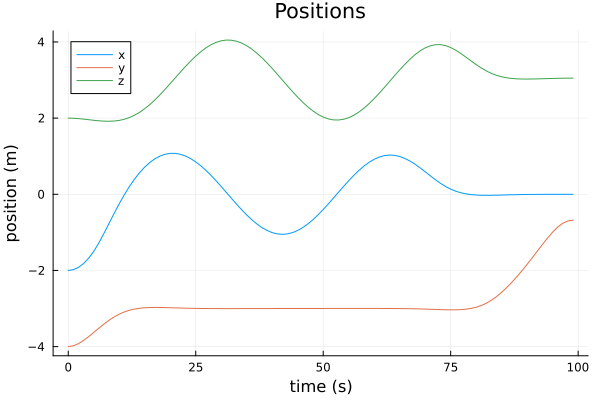

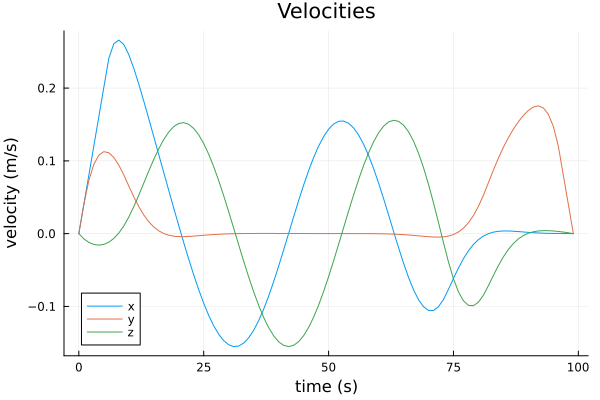

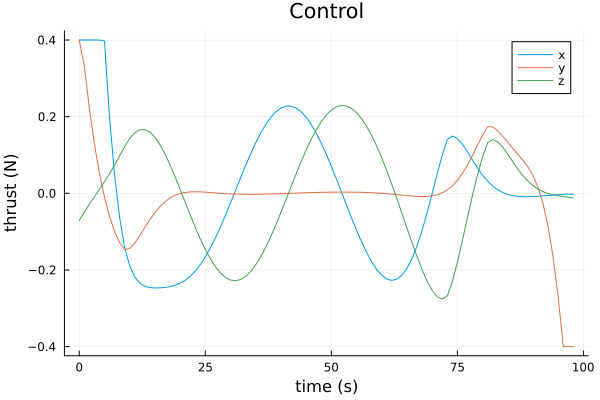

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("Background" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("top_color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x42, 0x61, 0x63, 0x6b, 0x67, 0x72, 0x6f, 0x75, 0x6e, 0x64]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("dragon" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x61, 0x67, 0x6f, 0x6e, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "iss" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x69, 0x73, 0x73, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "Lights" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("PointLightPositiveX" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x58, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "AmbientLight" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}("intensity" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(RawFD(51) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000000196498670, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

Test Summary:  | Pass  Total
convex trajopt |    7      7


Test.DefaultTestSet("convex trajopt", Any[], 7, false, false)

In [7]:
@testset "convex trajopt" begin 

    # create our discrete time model 
    dt = 1.0
    A,B = create_dynamics(dt)

    # get our sizes for state and control
    nx,nu = size(B)

    # initial and goal states
    x0 = [-2;-4;2;0;0;.0]
    xg = [0,-.68,3.05,0,0,0]

    # bounds on U
    u_max = 0.4*ones(3)
    u_min = -u_max

    # problem size and reference trajectory 
    N = 100 
    t_vec = 0:dt:((N-1)*dt)
    X_ref = desired_trajectory(x0,xg,N,dt) 
    
    # solve convex trajectory optimization problem 
    X_cvx, U_cvx = convex_trajopt(A,B,X_ref, x0,xg,u_min,u_max,N)
    
    X_sim = [zeros(nx) for i = 1:N]
    X_sim[1] = x0 
    for i = 1:N-1 
        X_sim[i+1] = A*X_sim[i] + B*U_cvx[i]
    end

    # -------------plotting/animation---------------------------
    Xm = mat_from_vec(X_sim)
    Um = mat_from_vec(U_cvx)
    display(plot(t_vec,Xm[1:3,:]',title = "Positions",
                 xlabel = "time (s)", ylabel = "position (m)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec,Xm[4:6,:]',title = "Velocities",
            xlabel = "time (s)", ylabel = "velocity (m/s)",
                 label = ["x" "y" "z"]))
    display(plot(t_vec[1:end-1],Um',title = "Control",
            xlabel = "time (s)", ylabel = "thrust (N)",
                 label = ["x" "y" "z"]))

    
    display(animate_rendezvous(X_sim, X_ref, dt;show_reference = false))
    # -------------plotting/animation---------------------------


    @test maximum(norm.( X_sim .- X_cvx, Inf)) < 1e-3 
    @test norm(X_sim[end] - xg) < 1e-3 # goal 
    xs=[x[1] for x in X_sim]
    ys=[x[2] for x in X_sim]
    zs=[x[3] for x in X_sim]
    @test maximum(ys) <= (xg[2] + 1e-3)
    @test maximum(zs) >= 4 # check to see if you did the circle 
    @test minimum(zs) <= 2 # check to see if you did the circle 
    @test maximum(xs) >= 1 # check to see if you did the circle 
    @test maximum(norm.(U_cvx,Inf)) <= 0.4 + 1e-3 # control constraints satisfied 

end